In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import DataRead
from sklearn.model_selection import train_test_split

In [2]:
characters, df_captcha, images = DataRead.readData()

In [3]:
df_captcha

,path,label
0,dataSet\8n56m.png,8n56m
1,dataSet\68wfd.png,68wfd
2,dataSet\6mygb.png,6mygb
3,dataSet\3w2bw.png,3w2bw
4,dataSet\42dw4.png,42dw4
...,...,...
1035,dataSet\56m6y.png,56m6y
1036,dataSet\ncyx8.png,ncyx8
1037,dataSet\nmy2x.png,nmy2x
1038,dataSet\bnc5f.png,bnc5f


In [4]:
print("Mevcut karakterler: ", characters)
print("Veri kümesindeki toplam örnek sayısı: ", len(df_captcha))

Mevcut karakterler:  ['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']
Veri kümesindeki toplam örnek sayısı:  1040


In [5]:
seed = 1234
np.random.seed(seed)
tf.random.set_seed(seed)

### Veri Setinin Train ve Test için Ayrılması

Veri setini öğrenme ve test için kümelere ayırdık. <span style="color:red"> Bu işlemi yaparken test kümesi boyutunu %20, öğrenme kümesi boyutunu %80 olacak şekilde ayarladık.</span> Veri setimizde 1040 adet resim bulunmaktadır. Bu durumda 832 adet öğrenme verisi, 208 adet test verisi elde etmiş bulunmaktayız.

In [6]:
# Veri kümesini eğitim ve doğrulama kümelerine ayır.
training_data, test_data = train_test_split(df_captcha, test_size=0.2, random_state=seed)

training_data = training_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

print("Eğitim örneği sayısı: ", len(training_data))
print("Test örneği sayısı: ", len(test_data))


Eğitim örneği sayısı:  832
Test örneği sayısı:  208


In [7]:
# Veri etiketini anahtarlama anahtarlama
char_to_labels = {char:idx for idx, char in enumerate(characters)}

# Veri etiketini numerik olarak anahtarlama
labels_to_char = {val:key for key, val in char_to_labels.items()}

char_to_labels

{'2': 0,
 '3': 1,
 '4': 2,
 '5': 3,
 '6': 4,
 '7': 5,
 '8': 6,
 'b': 7,
 'c': 8,
 'd': 9,
 'e': 10,
 'f': 11,
 'g': 12,
 'm': 13,
 'n': 14,
 'p': 15,
 'w': 16,
 'x': 17,
 'y': 18}

In [8]:
# Gelen chapta eğer bizim karakter dizimizden farklı bir karakter içeriyorsa false dönen fonksiyon.
def is_valid_captcha(captcha):
    for ch in captcha:
        if not ch in characters:
            return False
    return True

In [9]:
# Çok büyük bir veri kümesi olmadığı için dizileri bellekte saklayın
def generate_arrays(df, resize=True, img_height=50, img_width=200):
    
    len_items = len(df)
    images = np.zeros((len_items, img_height, img_width), dtype=np.float32)
    labels = [0]*len_items
    
    #resimleri siyah beyaza çevirme
    for i in range(len_items):
        img = cv2.imread(df["path"][i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        if resize: 
            img = cv2.resize(img, (img_width, img_height))
            
        #Verimizi kesirli hale çevirip, forma sokuyoruz. (Örneğin: 255 -> 255.0 -> 1.0)
        img = (img/255.).astype(np.float32)
        label = df["label"][i]
        
        # eğer karakter kontrolü boş dönüyorsa ekleme
        if is_valid_captcha(label):
            images[i, :, :] = img
            labels[i] = label
    
    return images, np.array(labels)

In [10]:
training_data, training_labels = generate_arrays(df=training_data)
print("Öğrenme resimlerinin sayısı ve size: ", training_data.shape)
print("Öğrenme etiketlerinin sayıs: ", training_labels.shape)

Öğrenme resimlerinin sayısı ve size:  (832, 50, 200)
Öğrenme etiketlerinin sayıs:  (832,)


In [11]:
# Test verisi oluşturma
test_data, test_labels = generate_arrays(df=test_data)
print("Test resimlerinin sayısı ve size: ", test_data.shape)
print("Test etiketlerinin sayısı: ", test_labels.shape)

Test resimlerinin sayısı ve size:  (208, 50, 200)
Test etiketlerinin sayısı:  (208,)


In [12]:
class DataGenerator(keras.utils.Sequence):
    #(Belirli bir veri kümesinden toplu işler üretir.)
    
    def __init__(self,
                 data,
                 labels,
                 char_map,
                 batch_size=16,
                 img_width=200,
                 img_height=50,
                 downsample_factor=4,
                 max_length=5,
                 shuffle=True
                ):
        self.data = data
        self.labels = labels
        self.char_map = char_map
        self.batch_size = batch_size
        self.img_width = img_width
        self.img_height = img_height
        self.downsample_factor = downsample_factor
        self.max_length = max_length
        self.shuffle = shuffle
        self.indices = np.arange(len(data))    
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))
    
    def __getitem__(self, idx):
        # 1. Sonraki toplu dizinleri alma
        curr_batch_idx = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        
        # Son partinin tüm partileri toplu iş_boyutu'na eşit öğelere sahip olmayabileceğinden, biraz bellekten tasarruf etmemize yardımcı olabilir.
        batch_len = len(curr_batch_idx)
#         print(batch_len)
        
        # Toplu dizileri örnekleme
        batch_images = np.ones((batch_len, self.img_width, self.img_height, 1),
                               dtype=np.float32)
        batch_labels = np.ones((batch_len, self.max_length), dtype=np.float32)
        input_length = np.ones((batch_len, 1), dtype=np.int64) * \
                                (self.img_width // self.downsample_factor - 2)
        label_length = np.zeros((batch_len, 1), dtype=np.int64)
        
        
        for j, idx in enumerate(curr_batch_idx):
            # 1. Resmi alın ve transpoze edin
            img = self.data[idx].T
            # 2. Ekstra boyut ekleyin
            img = np.expand_dims(img, axis=-1)
            # 3. İlgili etiketi alın
            text = self.labels[idx]
            # 4. Çifti yalnızca captcha geçerliyse dahil edin
            if is_valid_captcha(text):
                label = [self.char_map[ch] for ch in text]
                batch_images[j] = img
                batch_labels[j] = label
                label_length[j] = len(text)
        
        batch_inputs = {
                'input_data': batch_images,
                'input_label': batch_labels,
                'input_length': input_length,
                'label_length': label_length,
                }
        return batch_inputs, np.zeros(batch_len).astype(np.float32)
        
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

In [13]:
# Eğitim ve Doğrulama için küme boyutu.
# Her adımda kaç örneğin model parametrelerini değiştirmek için kullanılacağını belirtir.
batch_size = 16

# İstediğmiz görüntü boyutları
img_width=200
img_height=50 

# Pooling (Downsampling) Layer sayesinde görselde yer alan ağırlık azaltılmaya çalışılır ve azaltılan bu ağırlık doğrultusunda resmin parametrelere uygunluğu test edilir.
# Görüntünün evrişimsel bloklar tarafından alt örnekleneceği faktör
downsample_factor=4

# Verilerdeki herhangi bir captcha'nın maksimum uzunluğu
max_length=5

# Eğitim verileri için veri üreteci
train_data_generator = DataGenerator(data=training_data,
                                     labels=training_labels,
                                     char_map=char_to_labels,
                                     batch_size=batch_size,
                                     img_width=img_width,
                                     img_height=img_height,
                                     downsample_factor=downsample_factor,
                                     max_length=max_length,
                                     shuffle=True
                                    )

# Test verileri için veri üreteci
test_data_generator = DataGenerator(data=test_data,
                                     labels=test_labels,
                                     char_map=char_to_labels,
                                     batch_size=batch_size,
                                     img_width=img_width,
                                     img_height=img_height,
                                     downsample_factor=downsample_factor,
                                     max_length=max_length,
                                     shuffle=False
                                    )

In [14]:
print(train_data_generator[0])

({'input_data': array([[[[0.7529412 ],
         [0.7529412 ],
         [0.7529412 ],
         ...,
         [0.7647059 ],
         [0.7647059 ],
         [0.7647059 ]],

        [[0.7529412 ],
         [0.7529412 ],
         [0.7529412 ],
         ...,
         [0.7647059 ],
         [0.7647059 ],
         [0.7647059 ]],

        [[0.7529412 ],
         [0.7529412 ],
         [0.7529412 ],
         ...,
         [0.7647059 ],
         [0.7647059 ],
         [0.7647059 ]],

        ...,

        [[0.9843137 ],
         [0.9843137 ],
         [0.9843137 ],
         ...,
         [0.99607843],
         [0.99607843],
         [0.99607843]],

        [[0.9843137 ],
         [0.9843137 ],
         [0.9843137 ],
         ...,
         [0.99607843],
         [0.99607843],
         [0.99607843]],

        [[0.9843137 ],
         [0.9843137 ],
         [0.9843137 ],
         ...,
         [0.99607843],
         [0.99607843],
         [0.99607843]]],


       [[[0.7529412 ],
         [0.7529412 ]

# Model Oluşturma


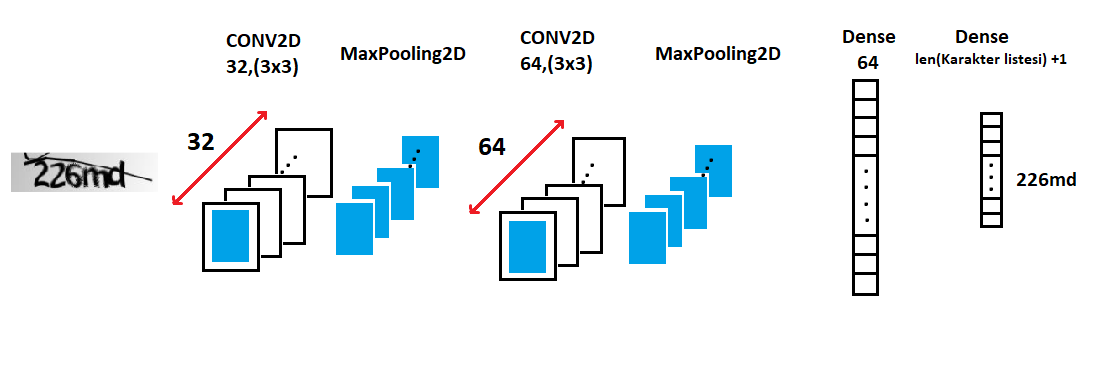


Model kısmında ilk olarak Conv.layer ile modele başlanmıştır. **<span style="color:red">Burada 32 ve 64 adet 3x3 lik filtreler kullanılmıştır.</span>**

**<span style="color:red">Convolutional Layer</span>**— Captcha'nın özelliklerini belirlemek için kullanılır. Filtreyi görüntü üzerinden hareket ettirerek ve matris çarpımını kullanarak, özelliklerimizi tespit ediyoruz. İlk filtreyi uyguladığımızda, bir Feature Map oluşturuyor ve bir özellik türünü tespit ediyoruz.

Ardından, ikinci bir filtre kullanıp daha iyi sonuç vermesi adına başka bir özellik türünü algılayan ikinci bir Feature Map oluşturuyoruz.

**<span style="color:red">Pooling Layer</span>**— Ağırlık sayısını azaltır ve uygunluğu kontrol eder. Bu katmanın görevi, gösterimin kayma boyutunu, içindeki parametreleri ve hesaplama sayısını azaltmak içindir. Bu sayede Feature Map'taki uyumsuzluk kontrol edilmiş olur. Görüntü matrisinin kanal sayısını(RGB veya grey) sabit tutarak yükseklik ve genişlik bilgisini azaltır.

Modeli compile etmek için optimizasyon  algoritması olarak Eski dost SGD (Stochastic Gradient Descent) algoritmasını kullandık. Bu hiperparametreler modelimizin daha çabuk eğitilmesinde etkili. Burada learning rate öğrenme hızımız. Decay parametresi öğrenme hızımızı zamanla azaltıyor. Momentum yöntemini kullanıyoruz. Bu parametre için genelde 0.9 değeri kullanılıyor. Momentum yönteminde bir hız vektörü tutuyoruz ve her adımda bunu update ediyoruz. Nesterov momentumu ise bunu biraz daha akıllı yapan, büyük bir adım attıktan sonra kendini düzelten bir yöntem. 

In [15]:
class findLossCTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred, input_length, label_length):
        # Eğitim-zaman kaybı değerini hesaplama ve ekleme
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        
        # Test zamanında, sadece hesaplanan kaybı döndürür
        return loss



def build_model():
    # Model inputlanırı verme
    input_img = layers.Input(shape=(img_width, img_height, 1),
                            name='input_data',
                            dtype='float32')
    labels = layers.Input(name='input_label', shape=[max_length], dtype='float32')
    input_length = layers.Input(name='input_length', shape=[1], dtype='int64')
    label_length = layers.Input(name='label_length', shape=[1], dtype='int64')
    
    # İlk Convolutional Layer
    # 32 adet 3x3 boyutunda filtereler oluşturulur.
    x = layers.Conv2D(32,
               (3,3),
               activation='relu',
               kernel_initializer='he_normal',
               padding='same',
               name='Conv1')(input_img)
    
    # İlk Pooling Layer
    x = layers.MaxPooling2D((2,2), name='pool1')(x)
    
    
    # İkinci Convolutional Layer 
    # 64 adet 3x3 boyutunda filtereler oluşturulur.
    x = layers.Conv2D(64,
               (3,3),
               activation='relu',
               kernel_initializer='he_normal',
               padding='same',
               name='Conv2')(x)
    
    # İkinci Pooling Layer
    x = layers.MaxPooling2D((2,2), name='pool2')(x)
    
    
    # 2 Basamaklı pooling layer kullandık. 
    # Bu nedenle, alt örneklenmiş özellik haritaları 4 kat daha küçüktür. Son katmandaki filtre sayısı 64'tür.
    # Buna göre yeniden şekillendirme yapılır
    
    new_shape = ((img_width // 4), (img_height // 4)*64)
    x = layers.Reshape(target_shape=new_shape, name='reshape')(x)
    x = layers.Dense(64, activation='relu', name='dense1')(x) #64 gizli katman
    x = layers.Dropout(0.2)(x)
    

    # Tahminler için karaket dizisinin boyutundan bir fazla uzunlukta gizli katman oluşturulur
    x = layers.Dense(len(characters)+1,
              activation='softmax', 
              name='dense2',
              kernel_initializer='he_normal')(x)
    
    # CTC'yi loss değerini hesaplama
    output = findLossCTCLayer(name='ctc_loss')(labels, x, input_length, label_length)
    
    # Modeli Tanımlama
    model = keras.models.Model(inputs=[input_img,
                                       labels,
                                       input_length,
                                       label_length],
                                outputs=output,
                                name='ocr_model_v1')
    
    # Compile fonksiyonunu kullanarak modelimizi nasıl eğiteceğimizi bildirmemiz gerekiyor. 
    # Bunun için bir optimizasyon algoritmasına ihtiyacımız olacak. SDG kullanıyoruz.
    sgd = keras.optimizers.SGD(learning_rate=0.002,
                               decay=1e-6,
                               momentum=0.9,
                               nesterov=True,
                               clipnorm=5)
    
    # Modeli compile(derleme) edip return ediyoruz.
    model.compile(optimizer=sgd)
    return model

In [16]:
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_data (InputLayer)        [(None, 200, 50, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 200, 50, 32)  320         ['input_data[0][0]']             
                                                                                                  
 pool1 (MaxPooling2D)           (None, 100, 25, 32)  0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 100, 25, 64)  18496       ['pool1[0][0]']       

In [17]:
# Modelin gelişimini tamamladığı noktada eğitimi durdurur.
# Early stopping
es = keras.callbacks.EarlyStopping(monitor='val_loss',
                                   patience=5,
                                   restore_best_weights=True)


# Modelimize verilerimizi veriyoruz ve eğitimimizi başlatıyoruz.
history = model.fit(train_data_generator,
                    validation_data=test_data_generator,
                    epochs=40,
                    verbose=2)


Epoch 1/40
52/52 - 11s - loss: 36.4613 - val_loss: 17.3160 - 11s/epoch - 206ms/step
Epoch 2/40
52/52 - 7s - loss: 16.4050 - val_loss: 16.5336 - 7s/epoch - 130ms/step
Epoch 3/40
52/52 - 7s - loss: 15.8633 - val_loss: 15.3695 - 7s/epoch - 132ms/step
Epoch 4/40
52/52 - 7s - loss: 13.6724 - val_loss: 11.5584 - 7s/epoch - 132ms/step
Epoch 5/40
52/52 - 7s - loss: 10.5335 - val_loss: 8.1884 - 7s/epoch - 132ms/step
Epoch 6/40
52/52 - 7s - loss: 7.8706 - val_loss: 5.8258 - 7s/epoch - 132ms/step
Epoch 7/40
52/52 - 7s - loss: 6.0537 - val_loss: 4.7161 - 7s/epoch - 132ms/step
Epoch 8/40
52/52 - 7s - loss: 5.1188 - val_loss: 3.7932 - 7s/epoch - 132ms/step
Epoch 9/40
52/52 - 7s - loss: 4.2422 - val_loss: 3.1271 - 7s/epoch - 131ms/step
Epoch 10/40
52/52 - 7s - loss: 3.6673 - val_loss: 2.8881 - 7s/epoch - 133ms/step
Epoch 11/40
52/52 - 7s - loss: 3.2993 - val_loss: 2.7301 - 7s/epoch - 132ms/step
Epoch 12/40
52/52 - 7s - loss: 2.9674 - val_loss: 2.3224 - 7s/epoch - 132ms/step
Epoch 13/40
52/52 - 7s - l

In [18]:
#Tahmin modelini oluşturma
prediction_model = keras.models.Model(model.get_layer(name='input_data').input,
                                        model.get_layer(name='dense2').output)
prediction_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_data (InputLayer)     [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 reshape (Reshape)           (None, 50, 768)           0         
                                                                 
 dense1 (Dense)              (None, 50, 64)            49216 

# Veri Kaybını Grafik ile Görselleştirme

<AxesSubplot:>

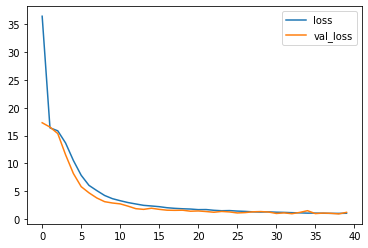

In [19]:
lossData = pd.DataFrame(model.history.history)
lossData
trainDataloss1 = pd.DataFrame(lossData["loss"])
trainDataloss2 = pd.DataFrame(lossData["val_loss"])
trainDataloss = pd.merge(trainDataloss1,trainDataloss2, right_index=True,left_index=True)
trainDataloss.plot()

In [20]:
# Ağın çıktısını çözmek için bir yardımcı program kullanma
def decode_batch_predictions(pred):
    pred = pred[:, :-2]
    input_len = np.ones(pred.shape[0])*pred.shape[1]
    
    # Açgözlü aramayı kullanılır
    results = keras.backend.ctc_decode(pred, 
                                        input_length=input_len,
                                        greedy=True)[0][0]
    
    # Sonuçları yineleyip ve metni output_text'e ekliyoruz
    output_text = []
    for res in results.numpy():
        outstr = ''
        for c in res:
            if c < len(characters) and c >=0:
                outstr += labels_to_char[c]
        output_text.append(outstr)
    
    return output_text

In [21]:
from pathlib import Path

Beklenen Sonuç: 25257 	 Tahmin: 25257
Beklenen Sonuç: 8d8ep 	 Tahmin: 8d8ep
Beklenen Sonuç: gfxcc 	 Tahmin: gfxcc
Beklenen Sonuç: bny4w 	 Tahmin: bny4w
Beklenen Sonuç: 8y6b3 	 Tahmin: 8y6b3
Beklenen Sonuç: y866y 	 Tahmin: y866y
Beklenen Sonuç: ecd4w 	 Tahmin: ecd4w
Beklenen Sonuç: w75w8 	 Tahmin: 758
Beklenen Sonuç: pn7pn 	 Tahmin: pn7pm
Beklenen Sonuç: gewfy 	 Tahmin: gewfy
Beklenen Sonuç: 5bb66 	 Tahmin: 5bb66
Beklenen Sonuç: yd38e 	 Tahmin: yd38e
Beklenen Sonuç: 6n5fd 	 Tahmin: 6n5fd
Beklenen Sonuç: pp546 	 Tahmin: pp546
Beklenen Sonuç: bgd4m 	 Tahmin: bgd4m
Beklenen Sonuç: n3ffn 	 Tahmin: n3ffn


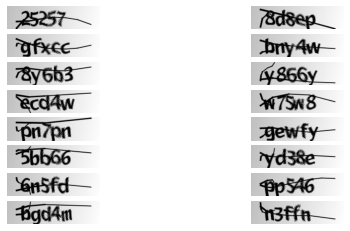

In [22]:
# Modelimizin başarısını ölçelim:
data_dir = Path("./dataSet/")
for p, (inp_value, _) in enumerate(test_data_generator):
    value = inp_value['input_data'].shape[0]
    X_data = inp_value['input_data']
    labels = inp_value['input_label']
    test_img = []    
    preds = prediction_model.predict(X_data)
    prediction_texts = decode_batch_predictions(preds)
    

    
    original_texts = []
    for label in labels:
        text = ''.join([labels_to_char[int(x)] for x in label])
        original_texts.append(text)
        
    for i in range(value):
        
        print(f'Beklenen Sonuç: {original_texts[i]} \t Tahmin: {prediction_texts[i]}')
        test_img.append("dataSet\\"+original_texts[i]+".png")
    
    test_images = test_img[:value]
    size_len = value / 2
    _,ax = plt.subplots(int(size_len),2, figsize=(8,4))
    for i in range(len(test_images)):
        img = cv2.imread(str(test_images[i]))
        ax[i//2, i%2].imshow(img)
        ax[i//2, i%2].axis('off')
    plt.show()

        
    break